In [2]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
import os
import pandas as pd
import random
import csv
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline



gtf = "c_elegans.PRJNA13758.WS258.canonical_geneset_plu_NO_inside_genes_same_strand.BedGraph"

rep = "WS258_tandem_and_inverted_repeats.gff"

df_dogdo = pd.read_csv("HS_combined_DOG_noOperon_unique_under_padj05_do.csv", sep=",")
df_dogup = pd.read_csv("HS_combined_DOG_noOperon_unique_under_padj05_up.csv", sep=",")
df_dogALL = pd.read_csv("HS_combined_ADOG_noOperon.csv", sep="\t")
df_dognonsig = df_dogALL[df_dogALL["padj"] > 0.05].copy()


def get_chrm_dic(df_gtf):
    """This function will take a gtf and return dictionary of different chrm. And clean the gtf for parsing"""
    df_gtf = df_gtf.copy()
    #Make df of chrom
    names=df_gtf['chr'].unique().tolist()
    d_gtf_chr = {chrom : df_gtf.loc[df_gtf.chr==chrom] for chrom in names}
    return d_gtf_chr

In [3]:
my_col = ["chr","start","end","gene_id_name"]
df_gtf = pd.read_csv(gtf, sep="\t",header=None,names=my_col, dtype={"chr": str, "start": int, "end": int, "gene_id": str}, low_memory=False)
df_gtf = df_gtf[~df_gtf["chr"].str.contains("\.") ]    # Take out patches
df_gtf["length"] = df_gtf["end"] - df_gtf["start"]
df_gtf = df_gtf.dropna()
chr_names=df_gtf['chr'].unique().tolist()

d_gtf = get_chrm_dic(df_gtf)
#Longest dog is 23000

In [4]:
def make_random_end(df_gtf):
    df_gtf = df_gtf.sort_values("start")
    df_gtf["next_gene_start"] = df_gtf["start"].shift(-1)
    df_gtf["next_gene_start-end"] = df_gtf["next_gene_start"] - df_gtf["end"]

    df_gtf["random_length"] = 0
    def get_random(R):
        R = R + random.choice(doglengths)
        # R = R + random.randint(100,23000) # Go from 100 to highest dog length
        return R

    df_gtf["random_length"] = df_gtf["random_length"].apply(get_random) 
    df_gtf["random_intergenic_end"] = df_gtf["end"] + df_gtf["random_length"]
    df_gtf["random_intergenic_end_no_overlap"] = np.where(df_gtf["random_intergenic_end"]>df_gtf["next_gene_start"], df_gtf["next_gene_start"], df_gtf["random_intergenic_end"] )
    df_gtf["start"] = df_gtf["start"].astype(int)
    return df_gtf

In [5]:
df_HS_ALL = pd.concat([df_dogup, df_dogdo])
doglengths = df_HS_ALL["DOG_length"].tolist()

for chr in d_gtf.keys():
    d_gtf[chr] = make_random_end(d_gtf[chr])

/Users/M/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [6]:
#Make chr dics of repeats
df_rep = pd.read_csv(rep,sep="\t",
                    names=["chr","type","type2","start","end","unknownnum","dot1","dot2","note"],)



df_rep = df_rep[["chr","start","end","type"]]

# # I	inverted	inverted_repeat	1	212	66	.	.	Note=loop 426
df_tir = df_rep[df_rep["type"]=="inverted"]
d_tir = get_chrm_dic(df_tir)
df_tan = df_rep[df_rep["type"]=="tandem"]
d_tan = get_chrm_dic(df_tan)

In [7]:
def get_overlap_count(df_rep, start,end):
    try:
        rows_df = df_rep[ (start < df_rep["start"]) & (df_rep["start"] < end) ]
        if len(rows_df) > 0:
            return len(rows_df)
        else:
            return 0
    except:
        print("no worky")



df_final = pd.DataFrame()
for chr in d_gtf.keys():
    print("working on chr", chr)
    df = d_gtf[chr]
    dftir = d_tir[chr]
    df["tir_overlap_count"] = df.apply(lambda row: get_overlap_count(dftir, row["start"],row["end"]), axis=1)  
    df["tir_overlap_count_over_length"] = df["tir_overlap_count"] / df["random_length"]
    dftan = d_tan[chr]
    df["tan_overlap_count"] = df.apply(lambda row: get_overlap_count(dftan, row["start"],row["end"]), axis=1)  
    df["tan_overlap_count_over_length"] = df["tan_overlap_count"] / df["random_length"]
    df_final = df_final.append(df)

df_final.to_csv("WS258_tan_tir_counts.csv", sep="\t", index=None)

working on chr MtDNA
working on chr IV
working on chr III
working on chr X
working on chr I
working on chr V
working on chr II


In [8]:
def get_tir_tan(df):
    d = get_chrm_dic(df)
    df_final = pd.DataFrame()
    for chr in d.keys():
        print("working on chr", chr)
        df = d[chr]
        dftir = d_tir[chr]
        df["tir_overlap_count"] = df.apply(lambda row: get_overlap_count(dftir, row["start"],row["end"]), axis=1)  
        df["tir_overlap_count_over_length"] = df["tir_overlap_count"] / df["DOG_length"]
        dftan = d_tan[chr]
        df["tan_overlap_count"] = df.apply(lambda row: get_overlap_count(dftan, row["start"],row["end"]), axis=1)  
        df["tan_overlap_count_over_length"] = df["tan_overlap_count"] / df["DOG_length"]
        df["length"] = df["DOG_length"]
        df = df[["gene_id_name","length","tir_overlap_count","tir_overlap_count_over_length","tan_overlap_count","tan_overlap_count_over_length"]]   
        
        df_final = df_final.append(df)
    return df_final






df_dogdo = get_tir_tan(df_dogdo)
df_dogup = get_tir_tan(df_dogup)  
df_dognonsig = get_tir_tan(df_dognonsig)

df_dogdo["annotation"] = "HS \n enriched DOG"
df_dogup["annotation"] = "HS \n depleted DOG"
df_dognonsig["annotation"] = "HS \n non sig DOG"
df_final["annotation"] = "WS258 \n random intergenic"

working on chr IV
working on chr III
working on chr V
working on chr II
working on chr I
working on chr X
working on chr IV
working on chr X
working on chr I
working on chr II
working on chr V
working on chr III
working on chr IV
working on chr III
working on chr X
working on chr I
working on chr V
working on chr II


In [9]:
df_final["length"] = df_final["random_length"]


df = pd.concat([df_final,df_dogup,df_dogdo])
df = df[["gene_id_name","annotation","length","tir_overlap_count","tir_overlap_count_over_length","tan_overlap_count","tan_overlap_count_over_length"]]
df.to_csv("dogs_tir_tan.csv",sep="\t",index=None)

/Users/M/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [10]:
#T test
from scipy.stats import ttest_ind


cat1 = df[df['annotation']=='HS enriched DOG']
cat2 = df[df['annotation']=='WS258 random intergenic']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

In [11]:
cat1 = df[df['annotation']=='HS depleted DOG']
cat2 = df[df['annotation']=='WS258 random intergenic']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

In [12]:
cat1 = df[df['annotation']=='HS enriched DOG']
cat2 = df[df['annotation']=='HS depleted DOG']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

In [13]:
cat1 = df[df['annotation']== "HS non sig DOG"]
cat2 = df[df['annotation']=='WS258 random intergenic']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

In [14]:
len(df_final)

21005

In [15]:
df_sample_final = pd.DataFrame()
for x in range(0,10000):
    df_sample = df_final.sample(50)
    mean = df_sample["tir_overlap_count_over_length"].mean()
    # df_sample_final["tir_50_random_sampled_mean"].iloc[x] = mean
    df_mean = [{'tir_overlap_count_over_length': mean, "annotation" : "WS258 \n random intergenic"}]
    df_mean = pd.DataFrame(df_mean)
    df_sample_final = df_sample_final.append(df_mean)

# df_sample_final

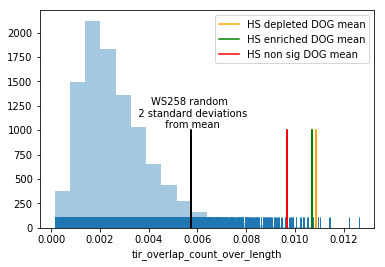

In [18]:
# Histogram plot
df_hist = df_sample_final['tir_overlap_count_over_length']#.iloc[:10000]
MEAN = df_hist.mean()
SD = df_hist.std() 
twoSDfrom_mean = MEAN + SD + SD
x1, x2 = twoSDfrom_mean , twoSDfrom_mean
y = 0
h = 1000
col = "k"
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "WS258 random \n  2 standard deviations \n from mean", ha='center', va='bottom', color=col)


dogdomean = df_dogdo["tir_overlap_count_over_length"].mean()
x1, x2 = dogdomean, dogdomean
y = 0
h = 1000
col = "k"
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c="orange", label="HS depleted DOG mean")

dogupmean = df_dogup["tir_overlap_count_over_length"].mean()
x1, x2 = dogupmean, dogupmean
y = 0
h = 1000
col = "k"

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c="green", label="HS enriched DOG mean")

dognonsigmean = df_dognonsig["tir_overlap_count_over_length"].mean()
x1, x2 = dognonsigmean, dognonsigmean
y = 0
h = 1000
col = "k"
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c="red", label="HS non sig DOG mean")
plt.legend()
sns.distplot(df_hist, bins=20, kde=False, rug=True);

plt.savefig("tir_overlap_count_over_length_10000_histogram.png", dpi=1000)

/Users/M/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


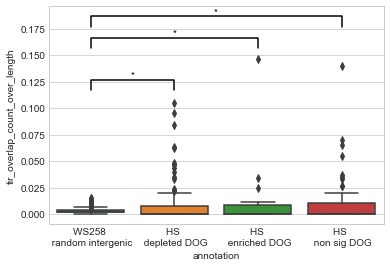

In [54]:
df = pd.concat([df_sample_final,df_dogup,df_dogdo, df_dognonsig])
df = df[["gene_id_name","annotation","length","tir_overlap_count","tir_overlap_count_over_length","tan_overlap_count","tan_overlap_count_over_length"]]
df.to_csv("dogs_tir_tan.csv",sep="\t",index=None)

ax = sns.boxplot(x="annotation",y="tir_overlap_count_over_length", data=df)
ax.ticklabel_format(style='plain', axis='y')
fig = ax.get_figure()


x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y = df['tir_overlap_count_over_length'].max()-.03
h = .01
col = "k"
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


x1, x2 = 0, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y = df['tir_overlap_count_over_length'].max()+.01
h = .01
col = "k"
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


x1, x2 = 0, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y = df['tir_overlap_count_over_length'].max()+.03
h = .01
col = "k"
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
plt.show()

fig.savefig("tir_overlap_count_over_length_sample50.png")

In [55]:
#T test
from scipy.stats import ttest_ind


cat1 = df[df['annotation']=='HS \n enriched DOG']
cat2 = df[df['annotation']=='WS258 \n random intergenic']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=18.897619769448379, pvalue=2.7154218562543642e-78)

In [56]:
cat1 = df[df['annotation']=='HS \n depleted DOG']
cat2 = df[df['annotation']=='WS258 \n random intergenic']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=28.571154639126501, pvalue=1.0302129059928045e-172)

In [57]:
cat1 = df[df['annotation']=='HS \n enriched DOG']
cat2 = df[df['annotation']=='HS \n depleted DOG']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=0.030181566697073663, pvalue=0.97597795351487415)

In [58]:
cat1 = df[df['annotation']=='HS \n non sig DOG']
cat2 = df[df['annotation']=='WS258 \n random intergenic']
ttest_ind(cat1['tir_overlap_count_over_length'], cat2['tir_overlap_count_over_length'], equal_var=True)

Ttest_indResult(statistic=24.106857088731552, pvalue=7.0174418054136621e-125)